# Homework \#8

RANSAC Localization



## Import Modules

In [100]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import mae6292.tools as mae6292
import importlib

from mae6292.imshow import cv2_imshow

## Load Data
The following data are given:

1.  Database image `data/000000.png`
2.  Keypoints in the database image `data/keypoints.txt`
3.  3D location of the keypoints in the W-frame `data/p_W_landmarks.txt`

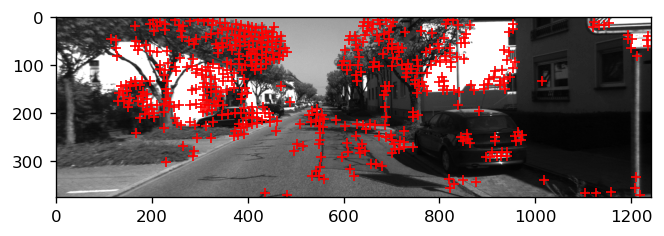

In [101]:
img_database = cv2.imread('data/000000.png',cv2.IMREAD_GRAYSCALE)
keypoints_database = list(map(tuple, np.loadtxt('data/keypoints.txt', dtype='int')-1)) # list of (row, col)
K = np.loadtxt('data/K.txt')
p_W_landmarks = np.loadtxt('data/p_W_landmarks.txt').T

plt.figure(dpi=120)
plt.imshow(img_database,cmap='gray')
plt.plot(np.array(keypoints_database).T[1,:],np.array(keypoints_database).T[0,:],'r+')

## RANSAC Localization

The following codes regenerate the results dicussed in the class for the first frame. Note that the frame number is defined by the variable `i_frame =1`

In [102]:
W_harris_patch = 4 # size of Harris patch
harris_kappa = 0.08 # parameters of Harris score
W_nms = 8 # size of non-maximum suppresion for keypoints seclection
W_descriptor = 9 # size of descriptor patch
lambda_match = 6 # paramter of descriptor matching

# Initial values
# N_keypoint = 1000 # number of keypoints 
# N_iter = 1000 # number of RANSAC iteration
# tol_inlier = 10 # tolerance of RANSIC inliner in pixels

#New values of the 3 parameters
N_keypoint = 1600
N_iter = 1700
tol_inlier = 12

# 1. imq_database: compute descriptor
descriptors_database = mae6292.describe_keypoints(img_database, keypoints_database, W_descriptor)

# 2. imq_query: load query image, detect keypoints, and compute descriptor
i_frame = 1
img_query_filename = "data/{:06d}.png".format(i_frame)   
img_query = cv2.imread(img_query_filename,cv2.IMREAD_GRAYSCALE)
harris_score_query = mae6292.harris_corner(img_query, W_harris_patch, harris_kappa)
keypoints_query = mae6292.select_keypoints(harris_score_query, N_keypoint, W_nms)
descriptors_query = mae6292.describe_keypoints(img_query, keypoints_query, W_descriptor)

# 3. match descriptors 
match, distance = mae6292.match_descriptors(descriptors_query, descriptors_database, lambda_match)
index_match = np.where(match>=0)[0].tolist()

# 4. extract matched keypoints and 3D world coordinates
keypoints_query_matched = [keypoints_query[i] for i in index_match]
keypoints_database_matched = [keypoints_database[match[i]] for i in index_match]
p_W_matched = p_W_landmarks[:, match[index_match]]

p_matched = np.array(keypoints_query_matched).T 
p_matched = p_matched[[1,0],:] 
p_matched = np.concatenate((p_matched, np.ones((1,p_matched.shape[1])) ), axis=0) 
p_W_matched = p_W_landmarks[:, match[index_match]]
p_W_matched = np.concatenate((p_W_matched, np.ones((1,p_W_matched.shape[1])) ), axis=0) 

# 5. estimate pose with RANSAC
R, T, M, N_inliers, i_inliers = mae6292.estimate_pose_RANSAC_DLT(p_matched, p_W_matched, K, N_iter, tol_inlier, display_iter=True)
print(-R.T@T)


i_iter=6, N_inliers=3, w=0.01
i_iter=9, N_inliers=11, w=0.03
i_iter=83, N_inliers=22, w=0.07
i_iter=109, N_inliers=96, w=0.30
i_iter=123, N_inliers=227, w=0.71
i_iter=181, N_inliers=233, w=0.73
i_iter=241, N_inliers=235, w=0.73
i_iter=436, N_inliers=236, w=0.74
[[-0.01291563]
 [-0.01818525]
 [ 0.67176925]]


## Visualization

For the given estimated pose, the following codes visualize

1. the image frame with the matched keypoints
2. the top view of the estimated pose represented by an axes frame, and the keypoints, where the matched keypoints are denoted by a red marker

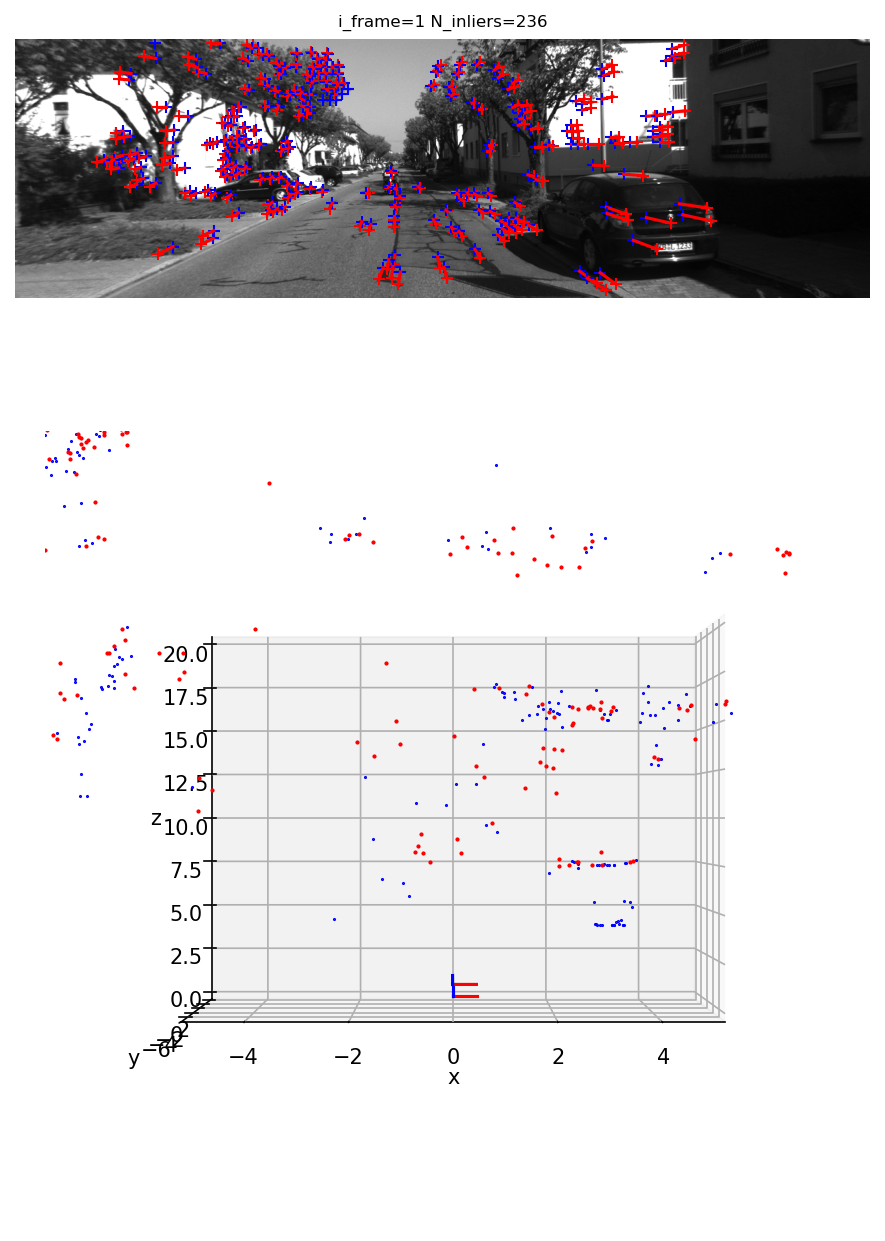

In [103]:
%matplotlib inline
fig = plt.figure(dpi=150,figsize=(6,10))

fig.add_subplot(2, 1, 1)
plt.imshow(img_query,cmap='gray')
plt.xticks([]), plt.yticks([])
plt.axis('off')
for i in i_inliers:
    v_q, u_q = keypoints_query_matched[i] # matched keypoints on img1
    v_d, u_d = keypoints_database_matched[i] # matched keypoints on img
    plt.plot(u_q, v_q, 'r+') 
    plt.plot(u_d, v_d, 'b+')
    plt.plot([u_d,u_q],[v_d,v_q],'r')
plt.title('i_frame='+str(i_frame)+' N_inliers='+str(N_inliers), fontsize=8)

ax = fig.add_subplot(2, 1, 2, projection='3d')
ax.plot(p_W_landmarks[0,:],p_W_landmarks[1,:],p_W_landmarks[2,:],'b.',markersize=1)
ax.plot(p_W_matched[0,i_inliers],p_W_matched[1,i_inliers],p_W_matched[2,i_inliers],'ro',markersize=1)
ax.set_xlim(-5,5)
ax.set_zlim(0,20)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=0., azim=-90)
mae6292.draw_frame(ax, np.identity(3), np.zeros((3,1)),axis_length=0.5)
mae6292.draw_frame(ax, R,T,axis_length=0.5)
plt.tight_layout()


## Problem 1

### (a) RANSAC DLT

We are going to apply the above RANSAC DLT localization for the subsequent 9 frames, and study its performance. 

1. Using a `for loop` repeat the above **RANSAC Localzation** (without **Visualization**) for the frames from `i_frame=1` to `i_frame=9`
2. Redefine `N_inliers` as an array or a list of 9 integers. Then, for each frame, save the number of inlliers to `N_inliers`
3. Generate a 2D plot for `N_inliers` with respect to `i_frame`, i.e., the horizontal axis is from 1 to 9, and the vertical axis is the number of N_inliers. Save it into `prob1.png`

Note that the results might alter everytime you run the code, because of the random selection in RANSAC. Repeat this several times and choose a reasonable result.  

i_iter=27, N_inliers=234, w=0.73
i_iter=85, N_inliers=235, w=0.73
i_iter=1322, N_inliers=236, w=0.74
i_iter=44, N_inliers=1, w=0.00
i_iter=51, N_inliers=145, w=0.55
i_iter=296, N_inliers=162, w=0.61
i_iter=312, N_inliers=173, w=0.65
i_iter=335, N_inliers=174, w=0.65
i_iter=115, N_inliers=1, w=0.00
i_iter=184, N_inliers=120, w=0.40
i_iter=46, N_inliers=1, w=0.00
i_iter=185, N_inliers=4, w=0.01
N_inliners= 4  is less than 6. Failed to estimate the pose
i_iter=343, N_inliers=1, w=0.01
i_iter=1630, N_inliers=2, w=0.01
N_inliners= 2  is less than 6. Failed to estimate the pose
i_iter=130, N_inliers=1, w=0.01
i_iter=548, N_inliers=2, w=0.01
i_iter=1228, N_inliers=5, w=0.03
N_inliners= 5  is less than 6. Failed to estimate the pose
i_iter=32, N_inliers=1, w=0.00
i_iter=534, N_inliers=2, w=0.01
N_inliners= 2  is less than 6. Failed to estimate the pose
i_iter=15, N_inliers=1, w=0.00
N_inliners= 1  is less than 6. Failed to estimate the pose
i_iter=47, N_inliers=1, w=0.00
i_iter=273, N_inliers=

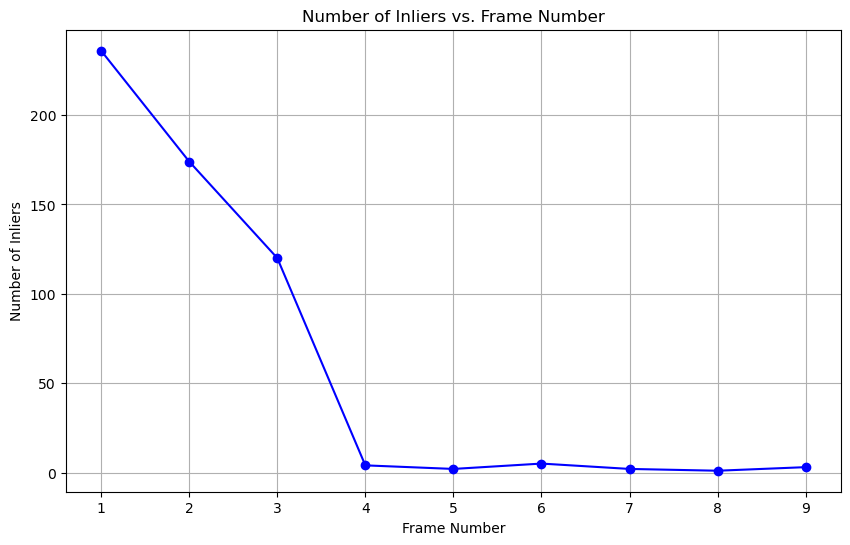

In [104]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Constants
W_harris_patch = 4
harris_kappa = 0.08
W_nms = 8
W_descriptor = 9
lambda_match = 6

# N_keypoint = 1000
# N_iter = 1000
# tol_inlier = 10

N_keypoint = 1600
N_iter = 1700
tol_inlier = 12

# Load database image and keypoints
img_database = cv2.imread('data/000000.png', cv2.IMREAD_GRAYSCALE)
keypoints_database = list(map(tuple, np.loadtxt('data/keypoints.txt', dtype='int')-1))
descriptors_database = mae6292.describe_keypoints(img_database, keypoints_database, W_descriptor)
K = np.loadtxt('data/K.txt')
p_W_landmarks = np.loadtxt('data/p_W_landmarks.txt').T

# Initialize list to store the number of inliers for each frame
N_inliers = []

# Pose estimation for frames 1 to 9
for i_frame in range(1, 10):  # Loop from frame 1 to 9
    img_query_filename = f"data/{i_frame:06d}.png"  
    img_query = cv2.imread(img_query_filename, cv2.IMREAD_GRAYSCALE)
    
    # Detect keypoints and compute descriptor for the query image
    harris_score_query = mae6292.harris_corner(img_query, W_harris_patch, harris_kappa)
    keypoints_query = mae6292.select_keypoints(harris_score_query, N_keypoint, W_nms)
    descriptors_query = mae6292.describe_keypoints(img_query, keypoints_query, W_descriptor)
    
    # Match descriptors between query and database
    match, distance = mae6292.match_descriptors(descriptors_query, descriptors_database, lambda_match)
    index_match = np.where(match >= 0)[0].tolist()
    
    # Extract matched keypoints and 3D world coordinates
    keypoints_query_matched = [keypoints_query[i] for i in index_match]
    keypoints_database_matched = [keypoints_database[match[i]] for i in index_match]
    p_W_matched = p_W_landmarks[:, match[index_match]]
    
    # Prepare data for pose estimation
    p_matched = np.array(keypoints_query_matched).T[[1, 0], :]
    p_matched = np.concatenate((p_matched, np.ones((1, p_matched.shape[1]))), axis=0)
    p_W_matched = np.concatenate((p_W_matched, np.ones((1, p_W_matched.shape[1]))), axis=0)
    
    # Estimate pose with RANSAC
    _, _, _, N_inliers_frame, _ = mae6292.estimate_pose_RANSAC_DLT(p_matched, p_W_matched, K, N_iter, tol_inlier)
    N_inliers.append(N_inliers_frame)

# Plotting N_inliers vs. frame number
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), N_inliers, marker='o', linestyle='-', color='b')
plt.title('Number of Inliers vs. Frame Number')
plt.xlabel('Frame Number')
plt.ylabel('Number of Inliers')
plt.xticks(range(1, 10))
plt.grid(True)

# Save the plot
plt.savefig('prob1b.png')
plt.show()


### (b) Discussion

Brifely discuss why the number of inliners decreases.

In [105]:
'''
The number of inliers might decrease due to factors such as changes in the scene variations in image quality,
or inaccuracies in keypoint matching.

(1)Decrease N_keypoint: means the algorithm has fewer features to match or to base the model estimation on.
    This can lead to more mismatches or incorrect geometric interpretations, increasing the number of outliers.
    However, too few keypoints might making it hard to estimate a model in the first place.
    
(2)Decrease N_iter:in an iterative algorithm (like RANSAC),can lead to an increase in outliers. This is because
    the algorithm has fewer chances to find a consistent set of inliers and hence might settle on a less optimal
    model that does not fit many of the observations.
    
(3)Increase tol_inlier: leads to a model that fits poorly to the data because it's too "forgiving" in what it considers
    as fitting.The actual effect of this change can be highly dependent on the data distribution.'''
    

'\nThe number of inliers might decrease due to factors such as changes in the scene variations in image quality,\nor inaccuracies in keypoint matching.\n\n(1)Decrease N_keypoint: means the algorithm has fewer features to match or to base the model estimation on.\n    This can lead to more mismatches or incorrect geometric interpretations, increasing the number of outliers.\n    However, too few keypoints might making it hard to estimate a model in the first place.\n    \n(2)Decrease N_iter:in an iterative algorithm (like RANSAC),can lead to an increase in outliers. This is because\n    the algorithm has fewer chances to find a consistent set of inliers and hence might settle on a less optimal\n    model that does not fit many of the observations.\n    \n(3)Increase tol_inlier: leads to a model that fits poorly to the data because it\'s too "forgiving" in what it considers\n    as fitting.The actual effect of this change can be highly dependent on the data distribution.'

## Problem 2

### (a) Tuning Parameters

Adjust the following three parameters, 
```
N_keypoint = 1000
N_iter = 1000
tol_inlier = 10
```
to increase the number of inliers from your results of **Problem 1** as much as you can. Save the selected paramters in the code. It is expected that everyone has a unique choice.

In [107]:
''' Initial values 
    N_keypoint = 1000 # number of keypoints 
    N_iter = 1000 # number of RANSAC iteration
    tol_inlier = 10 # tolerance of RANSIC inliner in pixels'''

# Adjusting parameters for RANSAC DLT localization
N_keypoint = 1600
N_iter = 1700
tol_inlier = 12

### (b) Visualization

For your chosen paramters, visualize the results using the code provided at the **Visualization** section. Save the image as `prob2_?.png`, where `?` corresponds to `i_frame`

i_iter=22, N_inliers=6, w=0.02
i_iter=42, N_inliers=235, w=0.73
i_iter=1051, N_inliers=236, w=0.74
i_iter=75, N_inliers=2, w=0.01
i_iter=118, N_inliers=3, w=0.01
i_iter=250, N_inliers=48, w=0.18
i_iter=494, N_inliers=171, w=0.64
i_iter=619, N_inliers=173, w=0.65
i_iter=0, N_inliers=1, w=0.00
i_iter=553, N_inliers=104, w=0.35
i_iter=68, N_inliers=1, w=0.00
i_iter=285, N_inliers=2, w=0.01
i_iter=1149, N_inliers=56, w=0.17
i_iter=38, N_inliers=1, w=0.01
i_iter=410, N_inliers=2, w=0.01
i_iter=527, N_inliers=5, w=0.03
N_inliners= 5  is less than 6. Failed to estimate the pose
i_iter=41, N_inliers=1, w=0.01
N_inliners= 1  is less than 6. Failed to estimate the pose
i_iter=69, N_inliers=1, w=0.00
i_iter=96, N_inliers=2, w=0.01
N_inliners= 2  is less than 6. Failed to estimate the pose
i_iter=173, N_inliers=1, w=0.00
N_inliners= 1  is less than 6. Failed to estimate the pose
i_iter=6, N_inliers=1, w=0.00
i_iter=10, N_inliers=2, w=0.01
N_inliners= 2  is less than 6. Failed to estimate the pose


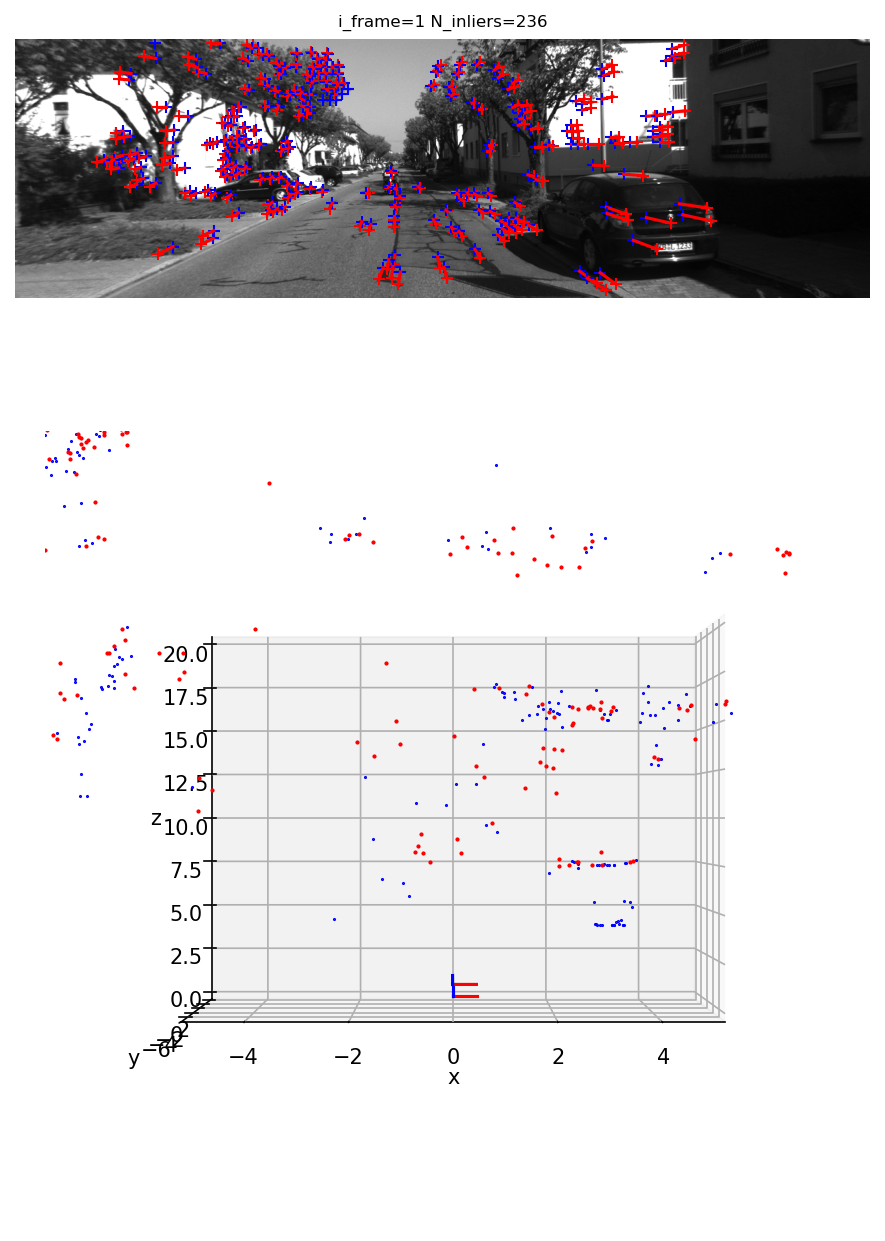

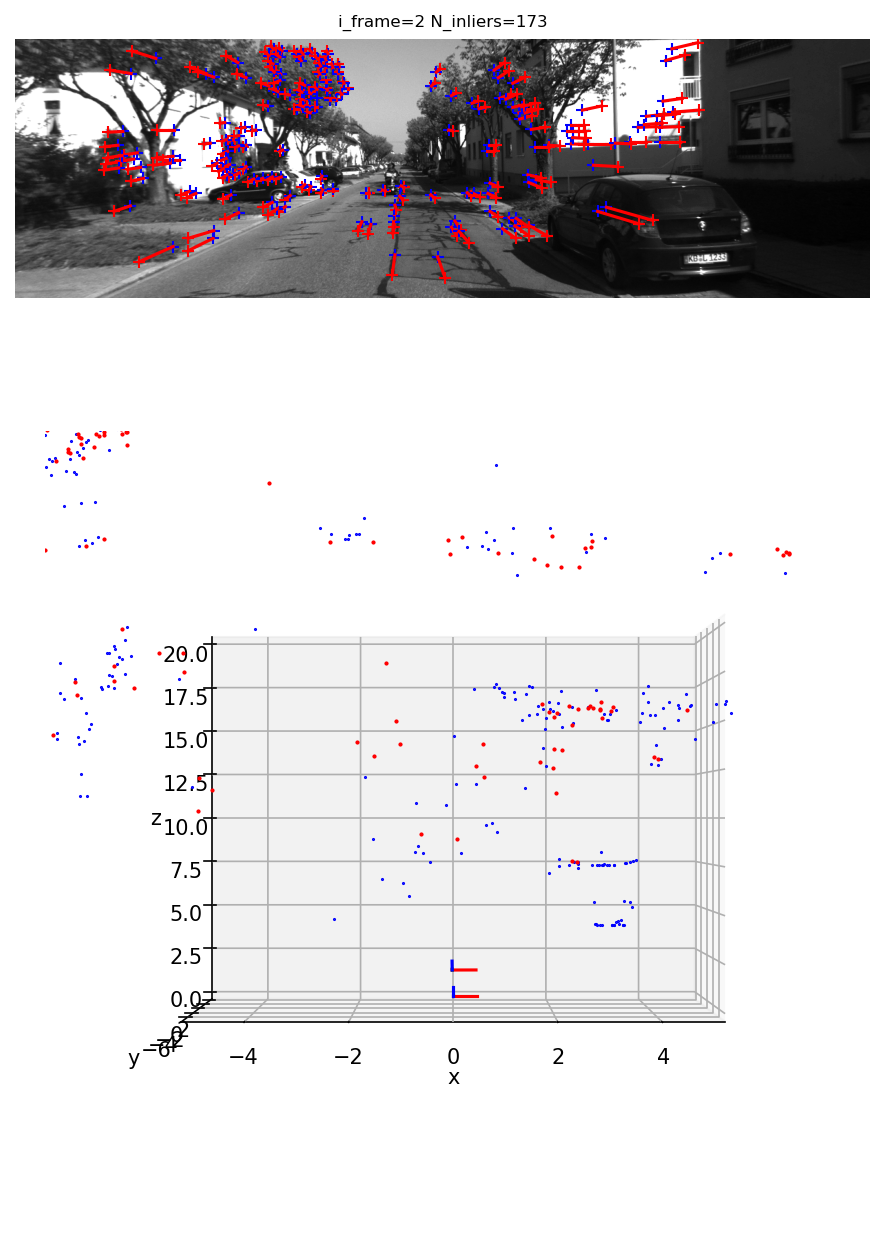

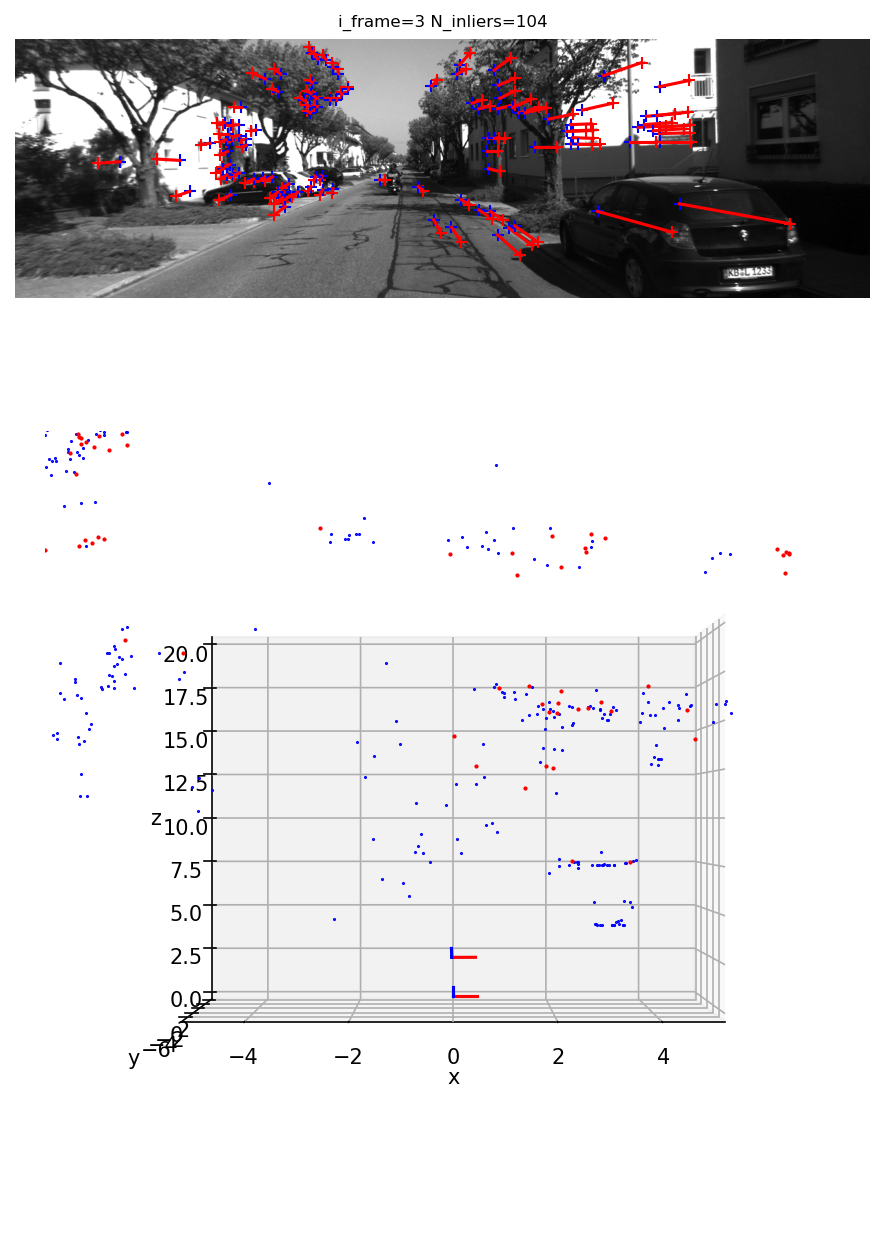

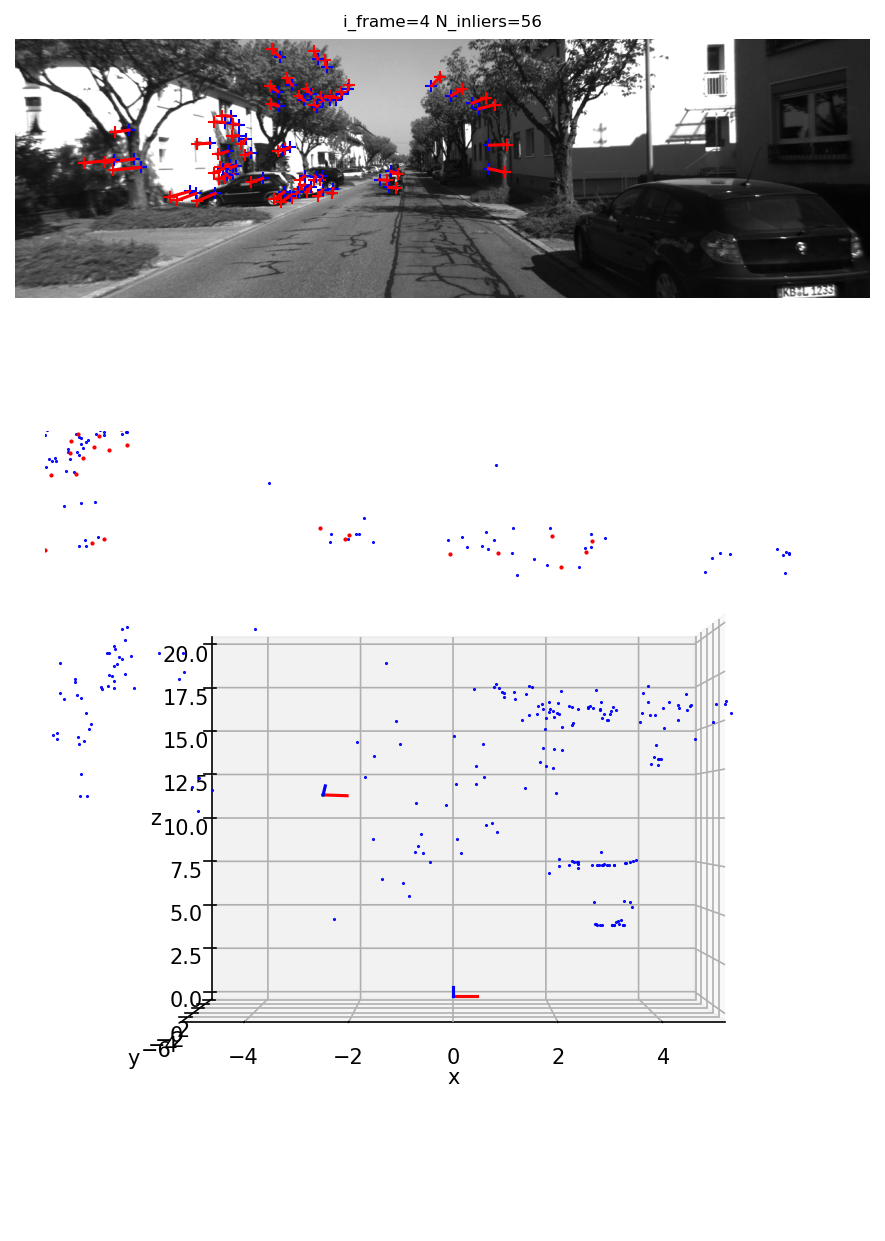

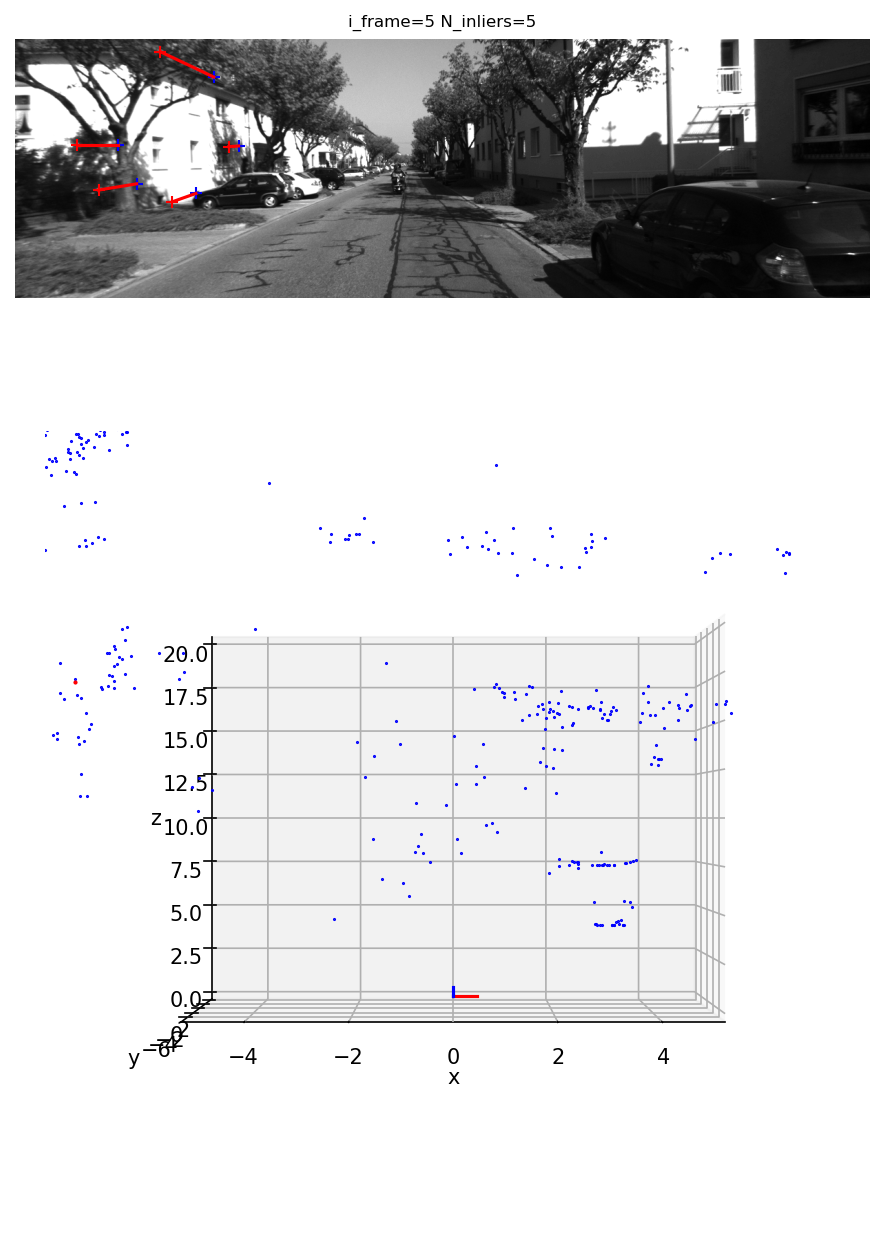

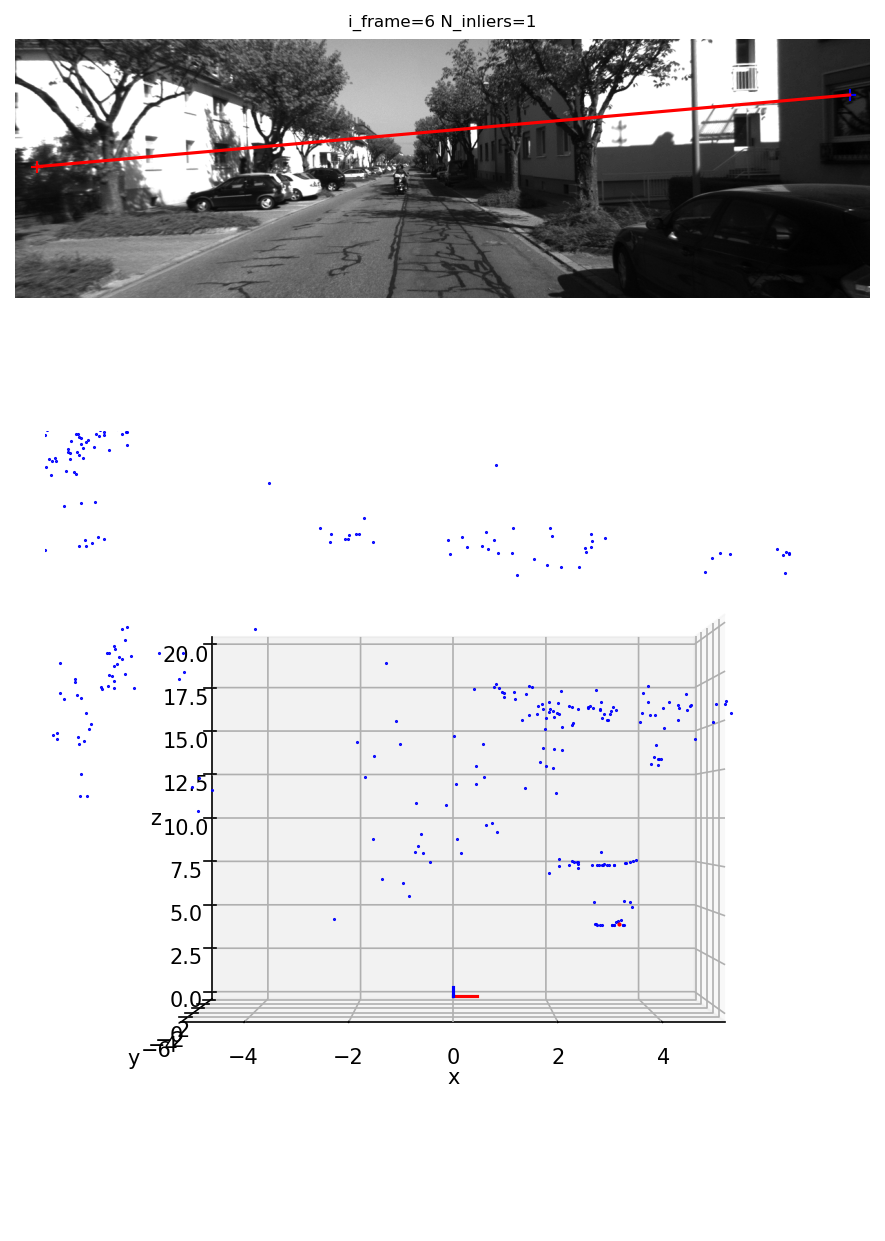

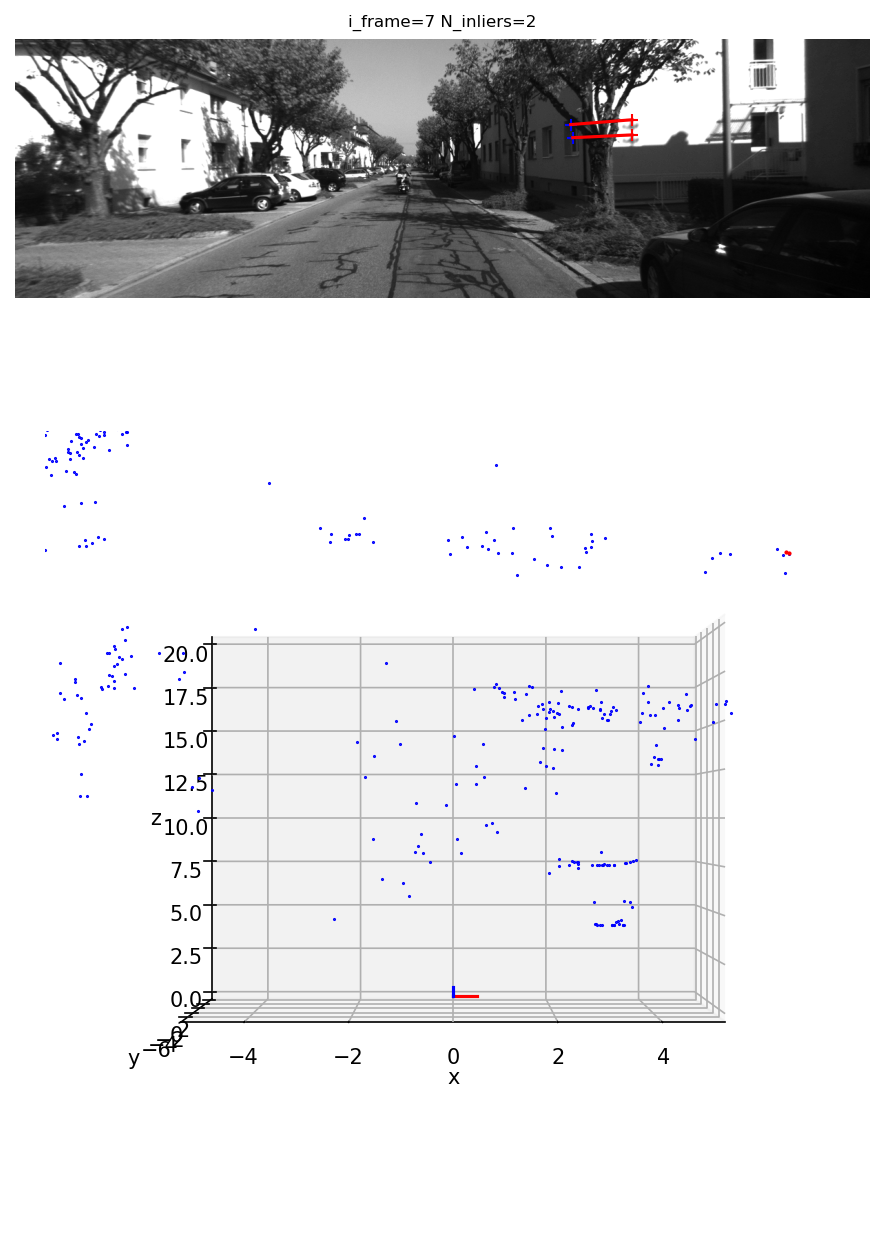

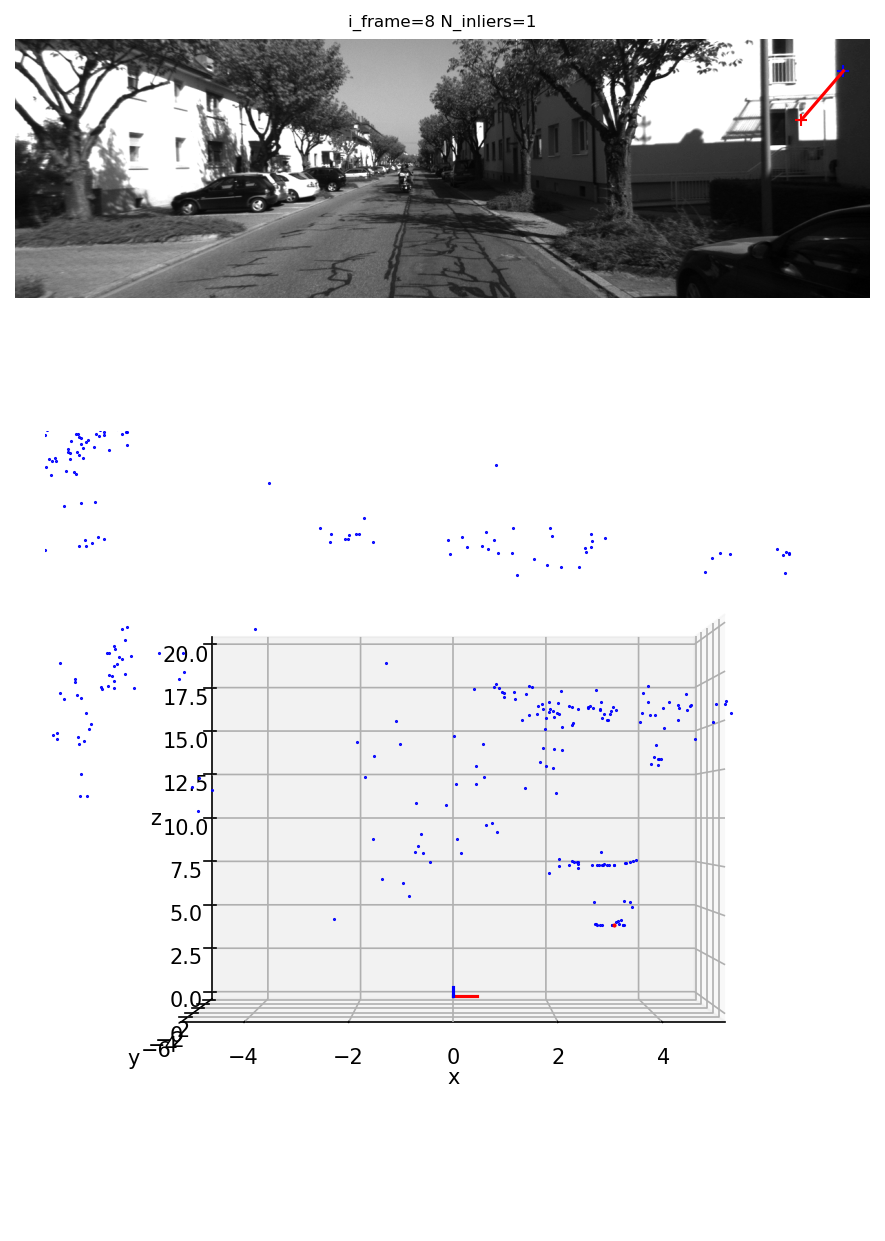

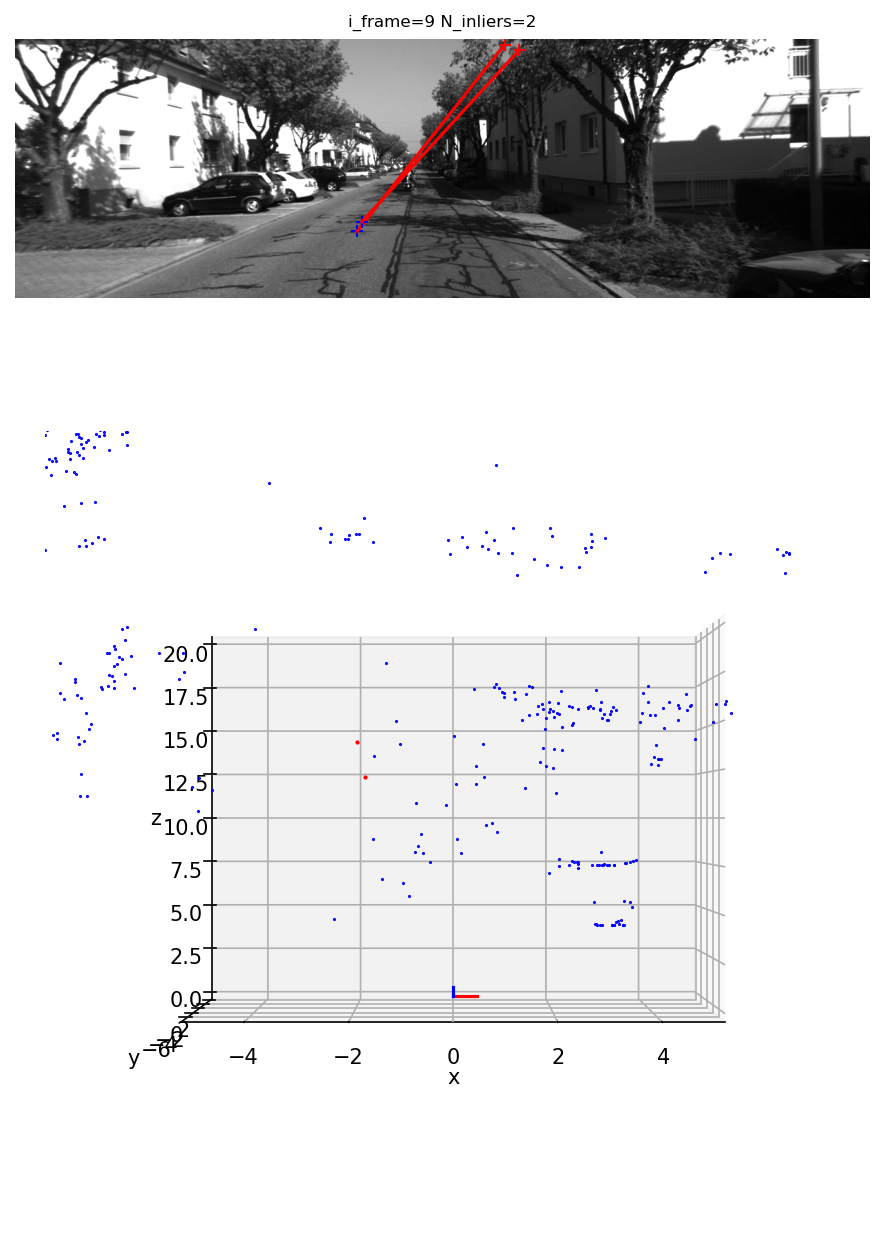

In [109]:


# 'i_frames' = frame identifiers (1 through 9 for 9 frames)
for i_frame in range(1,10):
    fig = plt.figure(dpi=150, figsize=(6, 10))
    
    W_harris_patch = 4 # size of Harris patch
    harris_kappa = 0.08 # parameters of Harris score
    W_nms = 8 # size of non-maximum suppresion for keypoints seclection
    W_descriptor = 9 # size of descriptor patch
    lambda_match = 6 # paramter of descriptor matching

    # New values of the 3 parameters
    N_keypoint = 1600
    N_iter = 1700
    tol_inlier = 12

    # 1. imq_database: compute descriptor
    descriptors_database = mae6292.describe_keypoints(img_database, keypoints_database, W_descriptor)

    # 2. imq_query: load query image, detect keypoints, and compute descriptor
    #i_frame = 1
    img_query_filename = "data/{:06d}.png".format(i_frame)   
    img_query = cv2.imread(img_query_filename,cv2.IMREAD_GRAYSCALE)
    harris_score_query = mae6292.harris_corner(img_query, W_harris_patch, harris_kappa)
    keypoints_query = mae6292.select_keypoints(harris_score_query, N_keypoint, W_nms)
    descriptors_query = mae6292.describe_keypoints(img_query, keypoints_query, W_descriptor)

    # 3. match descriptors 
    match, distance = mae6292.match_descriptors(descriptors_query, descriptors_database, lambda_match)
    index_match = np.where(match>=0)[0].tolist()

    # 4. extract matched keypoints and 3D world coordinates
    keypoints_query_matched = [keypoints_query[i] for i in index_match]
    keypoints_database_matched = [keypoints_database[match[i]] for i in index_match]
    p_W_matched = p_W_landmarks[:, match[index_match]]

    p_matched = np.array(keypoints_query_matched).T 
    p_matched = p_matched[[1,0],:] 
    p_matched = np.concatenate((p_matched, np.ones((1,p_matched.shape[1])) ), axis=0) 
    p_W_matched = p_W_landmarks[:, match[index_match]]
    p_W_matched = np.concatenate((p_W_matched, np.ones((1,p_W_matched.shape[1])) ), axis=0) 

    # 5. estimate pose with RANSAC
    R, T, M, N_inliers, i_inliers = mae6292.estimate_pose_RANSAC_DLT(p_matched, p_W_matched,
                                                                     K, N_iter, tol_inlier, display_iter=True)
   
    # Plot the first subplot
    fig.add_subplot(2, 1, 1)
    plt.imshow(img_query, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.axis('off')
    for i in i_inliers:
        v_q, u_q = keypoints_query_matched[i]  # matched keypoints on img1 for the current frame
        v_d, u_d = keypoints_database_matched[i]  # matched keypoints on img for the current frame
        plt.plot(u_q, v_q, 'r+')
        plt.plot(u_d, v_d, 'b+')
        plt.plot([u_d, u_q], [v_d, v_q], 'r')
    plt.title(f'i_frame={i_frame} N_inliers={N_inliers}', fontsize=8)

    # Plot the second subplot
    ax = fig.add_subplot(2, 1, 2, projection='3d')
    ax.plot(p_W_landmarks[0, :], p_W_landmarks[1, :], p_W_landmarks[2, :], 'b.', markersize=1)
    ax.plot(p_W_matched[0, i_inliers], p_W_matched[1, i_inliers], p_W_matched[2, i_inliers], 'ro', markersize=1)
    ax.set_xlim(-5, 5)
    ax.set_zlim(0, 20)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(elev=0., azim=-90)
    mae6292.draw_frame(ax, np.identity(3), np.zeros((3, 1)), axis_length=0.5)
    mae6292.draw_frame(ax, R, T, axis_length=0.5)
    plt.tight_layout()
    plt.savefig(f'prob2_{i_frame}.png')
    

### How To Submit

Attach

1.  `prob1.png`
2.  `prob2_1.png` ... `prob2_9.png`